<p><strong><font size="6">WALOUS</font></strong></p>

<p><strong><font size="6">Fusion LC classifications results</font></strong></p>

<p><strong><font size="6">Test validation</font></strong></p>

This python code implement the method developed by ANAGEO (ULB). 

Code developped on Linux Mint 18.1 (Ubuntu Xenial 16.04) and GRASS GIS 7.3.svn (r71315).

# Table of Contents

<div id="toc"></div>

The following cell is a Javascript section of code for building the Jupyter notebook's table of content.

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Define working environment

**Import libraries**

In [3]:
# Import libraries needed for setting parameters of operating system 
import os
import sys
import csv
import tempfile
import glob
import math
import pickle

** Add folder with SCR provided belong to this notebook**

In [21]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

** Setup environment variables for TAIS DESKTOP (Linux Mint + GRASS Dev) **

Please edit the file in `../SRC/config.py`, containing the configuration parameters, according to your own computer setup. The following cell is used to run this file.



In [22]:
run ../SRC/config.py

In [23]:
print config_parameters

{'outputfolder_classifRF_tiles': '../../../Results_V2/Classif_RF/classif_tiles', 'outputfolder_classifRF': '../../../Results_V2/Classif_RF', 'outputfolder_Logfile': '../../../Results_V2/Log_file', 'permanent_mapset': 'PERMANENT', 'outputfolder_training_sample': '../../../Results_V2/Training_sample', 'locationepsg': '31370', 'outputfolder': '../../../Results_V2', 'list_tiles': '../../../Results_V2/list_tiles', 'pixel_classes_list': '../../../Results_V2/pixel_classes_list', 'outputfolder_classifRF_csv': '../../../Results_V2/Classif_RF/classif_csv', 'gisdb': '../../GRASSDATA', 'location': 'WALOUS_31370', 'outputfolder_classfeatures': '../../../Results_V2/Classification_features', 'PYTHONLIB': '/usr/lib/python2.7', 'njobs': 6, 'outputfolder_classifRF_valid': '../../../Results_V2/Classif_RF/test_valid', 'rf_trained_model': '../../../Results_V2/Classif_RF/rf_trained_model.rda', 'GISBASE': '/usr/lib/grass76'}


In [24]:
# Import functions that setup the environmental variables
import environ_variables as envi

In [25]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

MDMSESSION = mate 	
MANDATORY_PATH = /usr/share/gconf/mate.mandatory.path 	
MATE_DESKTOP_SESSION_ID = this-is-deprecated 	
LESSOPEN = | /usr/bin/lesspipe %s 	
MDM_LANG = fr_BE.UTF-8 	
LOGNAME = tais 	
USER = tais 	
HOME = /home/tais 	
XDG_VTNR = 8 	
PATH = /usr/local/bin:/home/tais/BIN:/home/tais/bin:/home/tais/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/grass76/bin:/usr/lib/grass76/script:/usr/lib/grass76/lib:/usr/lib/grass76/bin:/usr/lib/grass76/scripts:/home/tais/.grass7/addons/scripts:/home/tais/.grass7/addons/bin:/usr/lib/grass76/bin:/usr/lib/grass76/scripts:/home/tais/.grass7/addons/scripts:/home/tais/.grass7/addons/bin:/usr/lib/grass76/bin:/usr/lib/grass76/script:/usr/lib/grass76/lib 	
CLICOLOR = 1 	
DISPLAY = :0.0 	
SSH_AGENT_PID = 1986 	
LANG = fr_BE.UTF-8 	
TERM = xterm-color 	
SHELL = /bin/bash 	
GIS_LOCK = $$ 	
XAUTHORITY = /home/tais/.Xauthority 	
SESSION_MANAGER = local/tais-HP-Z620-Workstation:@/tmp/.ICE-un

** GRASS GIS Python libraries **

In [26]:
# Import libraries needed to launch GRASS GIS in the jupyter notebook
import grass.script.setup as gsetup
# Import libraries needed to call GRASS using Python
import grass.script as gscript

** Other functions**

In [27]:
# Import function that check existance and create GRASS GIS database folder if needed
from grass_database import check_gisdb, check_location, check_mapset, working_mapset
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that generate a random name in the GRASS GIS environement
from random_layer_name import random_layer_name
# Import function that check and create folder
from mkdir import check_create_dir
# Import function that check if GRASS GIS add-on is installed and install it if needed
from gextension import check_install_addon
# Import function that change .csv delimiter
from ChangeCsvDelimiter import ChangeCsvDelimiter
# Import function for .gzip archive management
from gzip_management import decompress_gzip
# Import function for getting list of class of a raster
from data_prep import data_prep
# Import function the allow sorting strings with number as if they was number (natural order)
from sorting_natural import natural_keys

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

In [28]:
def launch_mapset(mapset):
    #Declare empty list that will contain the messages to return
    return_message = []
    # Check if the location exists and create it if not, with the CRS defined by the epsg code 
    return_message.append(check_location(config_parameters["gisdb"],config_parameters['location'],config_parameters["locationepsg"]))
    # Check if mapset exists
    return_message.append(check_mapset(config_parameters["gisdb"],config_parameters['location'],mapset))
    # Change the current working GRASS GIS session mapset
    return_message.append(working_mapset(config_parameters["gisdb"],config_parameters['location'],mapset))
    # Return
    return return_message

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

## Create new directory

In [29]:
# Check and create folder if needed
check_create_dir(config_parameters['outputfolder_classifRF_valid'])

The folder '../../../Results_V2/Classif_RF/test_valid' already exists


# Collect training data

## Create csv with list of validation point and their tile_id and seg_id 

In [30]:
# Create mapset 
launch_mapset("validation")

["Location 'WALOUS_31370' already exist",
 "'validation' mapset already exists in location 'WALOUS_31370'",
 "You are now working in mapset 'WALOUS_31370/validation'"]

In [32]:
# Allow access to other mapsets
gscript.run_command('g.mapsets', mapset='OBIA', operation='add')

0

In [33]:
# Import vector
gscript.run_command('v.in.ogr', overwrite=True, input=data['validation_points'][1], 
                    layer=data['validation_points_gpkg_layer'][2],
                    output=data['validation_points'][0])
gscript.run_command('g.region', raster='segmentation')
# Get only point within tile vector 
gscript.run_command('v.clip', overwrite=True, input=data['validation_points'][0], clip='tiles', 
                    output='%s_tmp'%data['validation_points'][0])
gscript.run_command('g.rename', overwrite=True, vector='{layer}_tmp,{layer}'.format(layer=data['validation_points'][0]))

0

In [34]:
# Add seg_id in attribute table
gscript.run_command('v.db.addcolumn', map=data['validation_points'][0], columns="seg_id integer")
gscript.run_command('v.what.rast', map=data['validation_points'][0], raster='segmentation', column='seg_id')

0

In [35]:
# Add Tile ID in attribute table
gscript.run_command('v.db.addcolumn', map=data['validation_points'][0], columns="tile_id integer")
gscript.run_command('v.what.vect', map=data['validation_points'][0], column='tile_id', 
                    query_map=data['tiles'][0], query_column='cat')

0

In [36]:
# Export attribute table as .csv
output_file = os.path.join(config_parameters['outputfolder_classifRF_valid'],'validation_points_with_segid.csv')
gscript.run_command('v.db.select', overwrite=True, 
                    map=data['training_points'][0], separator='comma', file=output_file)

0

## Get list of segment ID

In [159]:
# Read csv
csvfile = os.path.join(config_parameters['outputfolder_classifRF_valid'],"validation_points_with_segid.csv")
fin = open(csvfile)
reader = csv.reader(fin)
# Get list of seg_ID
list_segid = []
label_dic = {}
reader.next()
for row in reader:
    tilegid = row[-1] # row[-1] for 'tilegid'
    segid = row[-2] # row[-2] for 'seg_id'
    label = row[-3]  # row[-3] for label 'label_2018'
    if tilegid != "" and segid != "":
        twokeyid = "%s_%s"%(segid,tilegid)
        list_segid.append(twokeyid)   
        label_dic[twokeyid] = label
initial_count = len(list_segid)
# Keep only value that appear once
count = [list_segid.count(a) for a in list_segid]  # Get list of count for each value
list_segid = [list_segid[i] for i,a in enumerate(count) if a == 1]   # Keep only where count = 1
list_segid = [(x.split("_")[0],x.split("_")[1], label_dic["%s_%s"%(x.split("_")[0],x.split("_")[1])]) for x in list_segid]
unique_count = len(list_segid)

# Create dictionnary with unique segments+tile ID
validation_dic = {}
segid_list, tileid_list, label_list = zip(*list_segid)
for segid, tileid, label in zip(segid_list, tileid_list, label_list):
    if tileid not in validation_dic:
        validation_dic[tileid] = {}
    validation_dic[tileid][segid] = [label,]
    if "" in validation_dic[tileid]:
        del validation_dic[tileid][""]
if "" in validation_dic:
    del validation_dic[""]
    
# Print
print "%s segments out of the %s initially available will be used for training."%(unique_count,initial_count)

2910 segments out of the 2914 initially available will be used for training.


## Get list of csv file with predictions

In [163]:
# Get list of csv with classification feature of individual tiles
import glob
list_predict_csv = glob.glob(os.path.join(config_parameters['outputfolder_classifRF_csv'],"RF_fusion_tile_*.csv"))
print "%s .csv files with prediction in folder"%len(list_predict_csv)

375 .csv files with prediction in folder


In [164]:
list_predict_csv

['../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_2335.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_685.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_4691.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_6164.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_187.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_256.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_1181.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_5920.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_2401.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_1179.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_1208.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_2023.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_3510.csv',
 '../../../Results_V2/Classif_RF/classif_csv/RF_fusion_tile_711.csv',
 '../../..

## Get csv file with tile_id, seg_ig, validation_label and prediction

In [165]:
# Define path to training file
validationfile = os.path.join(config_parameters['outputfolder_classifRF_valid'],"validation_samples.csv")

In [166]:
import os,sys
import copy
overwrite=True
outputcsv = validationfile
# Check
if os.path.isfile(outputcsv) and overwrite==False:
    print "File '"+str(outputcsv)+"' aleady exists and overwrite option is not enabled."
    sys.exit()
else:
    if os.path.isfile(outputcsv) and overwrite==True:
        open(outputcsv,"r").close()
        os.remove(outputcsv)

# Initialization
available_csv = [os.path.split(a)[1].split(".csv")[0].split("_")[-1] for a in list_predict_csv]
remaining_dic = copy.deepcopy(validation_dic)
select_dic = {}
counter=0  #To count how many items will be find
fout = open(outputcsv,"a")  #Output csv
writer = csv.writer(fout)   #Writer for output
header = ['cat','tile_id','seg_id','validation_label','prediction_label']
writer.writerow(header)
# Start looking in list of .csv files
for tileid in validation_dic:
    if tileid in available_csv:
        classifcsv = os.path.join(config_parameters['outputfolder_classifRF_csv'],"RF_fusion_tile_%s.csv"%tileid)
        fin = open(classifcsv,"r")
        reader = csv.reader(fin)
        reader.next()
        for line in reader:
            if len(remaining_dic[tileid])==0: #If no remaining segid to look for in this tile
                break
            current_segid=line[0]
            if current_segid in validation_dic[tileid]:
                valid_label = line[1]
                counter+=1
                validation_dic[tileid][current_segid].append(valid_label) #Append the value of the prediction 
                newrow = []
                newrow.append(counter)  # Add 'cat'
                newrow.append(tileid)  # Add 'tile_id'
                newrow.append(current_segid)  # Add 'seg_id'
                newrow.append(valid_label)  # Add 'validation_label'                
                newrow.append(validation_dic[tileid][current_segid][0])  # Add 'prediction_label'
                writer.writerow(newrow)
                del remaining_dic[tileid][current_segid]
                if valid_label not in select_dic:
                    select_dic[valid_label] = []
                select_dic[valid_label].append(1)
fout.close()
count_remain = len([remaining_dic[subdic][key] for subdic in remaining_dic for key in remaining_dic[subdic]])
if counter==0:
    print "ERROR: Nothing found"
    os.remove(outputcsv)
    sys.exit()
if count_remain>0:  #If the research goes through all the .csv files in the list but still remain unfind items
    print "WARNING: %s item(s) not found."%count_remain
print "Process finished"

Process finished


## Count of point in each class

In [167]:
print "Number of samples per class \n\n"
for label in select_dic:
    print "Class '%s'        %s samples"%(label,sum(select_dic[label]))

Number of samples per class 


Class '11'        315 samples
Class '12'        130 samples
Class '42'        664 samples
Class '62'        55 samples
Class '41'        341 samples
Class '61'        25 samples
Class '3'        347 samples
Class '2'        108 samples
Class '5'        925 samples


## Compute confusion matrix and plot it

In [193]:
## Import libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
%matplotlib inline

In [194]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, ha='right', rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, round(cm[i, j],2),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [197]:
# Get a list with validation label and a list with prediction label
valid_list, predict_list = zip(*[(validation_dic[tile][segid][0], validation_dic[tile][segid][1]) 
                                 for tile in validation_dic.keys() 
                                 for segid in validation_dic[tile].keys()])

In [198]:
# Number of misclassification
len([a for i,a in enumerate(valid_list) if a <> predict_list[i]])

27

In [199]:
# Compute confusion matrix
cnf_matrix=confusion_matrix(valid_list, predict_list)

In [200]:
## Set the path to the output
output_rowconfmat=os.path.join(config_parameters['outputfolder_classifRF_valid'],"rowconfusionmatrix.txt")
## Export the row confusion matrix
np.savetxt(output_rowconfmat, cnf_matrix.astype(np.int), fmt='%d', delimiter=",")

In [204]:
# List of 
classes = ['Sol nu','Terre arable','Herbage','Articialise (sol)','Artificialise (contruction haute)','Conifere','Feuillus','Eau (cours)','Eau (plan)']

Confusion matrix, without normalization
Normalized confusion matrix


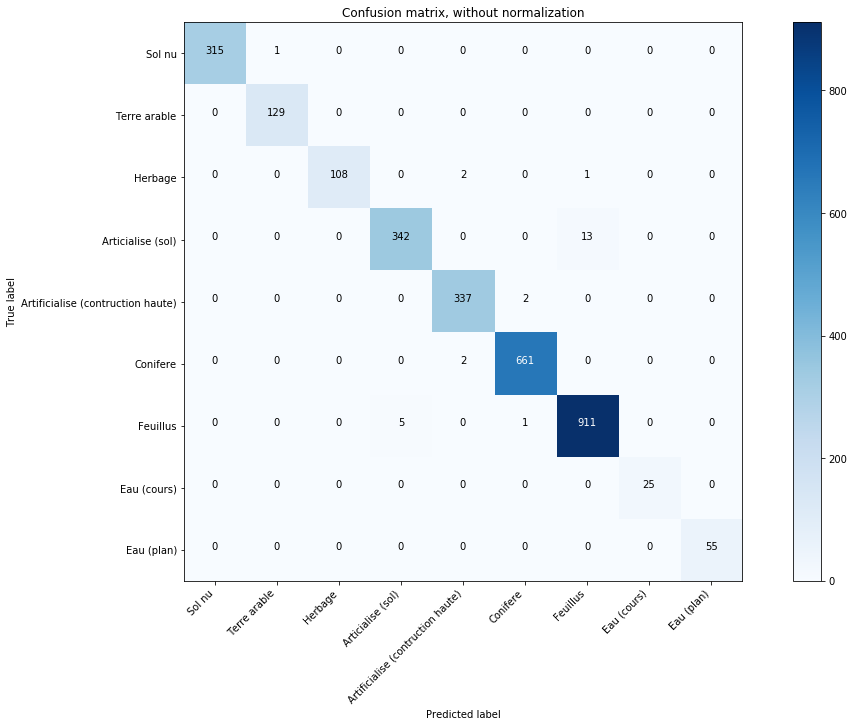

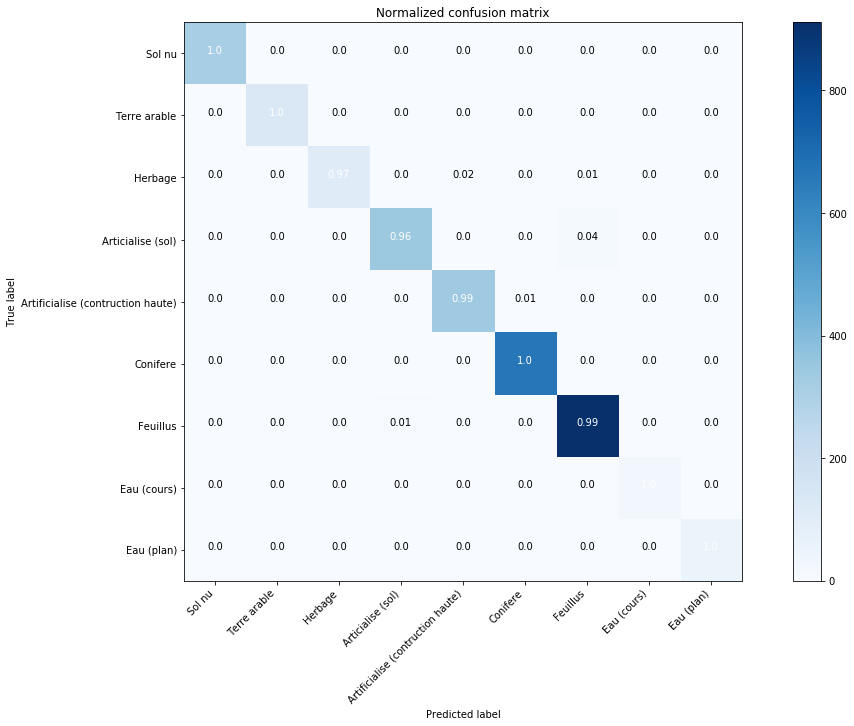

In [205]:
# Plot non-normalized confusion matrix
fig_cm=plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
fig_cm_normal=plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [209]:
## Set the path to the output
output_confmat_pdf=os.path.join(config_parameters['outputfolder_classifRF_valid'],"confusionmatrix.pdf")
output_confmatA_png=os.path.join(config_parameters['outputfolder_classifRF_valid'],"confusionmatrixA.png")
output_confmatB_png=os.path.join(config_parameters['outputfolder_classifRF_valid'],"confusionmatrixB.png")

In [210]:
# Export in PDF
from matplotlib.backends.backend_pdf import PdfPages
pp=PdfPages(output_confmat_pdf)
pp.savefig(fig_cm)
pp.savefig(fig_cm_normal)
pp.close()

# Export in PNG
fig_cm.savefig(output_confmatA_png, format='png', dpi=300)
fig_cm_normal.savefig(output_confmatB_png, format='png', dpi=300)

## Compute validation report

In [211]:
## Import libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score

In [212]:
## Set the path to the output
output=os.path.join(config_parameters['outputfolder_classifRF_valid'],"RF_classif_repport.txt")

In [214]:
# Define dataset to take into account
y_true=valid_list
y_pred=predict_list
class_label=classes

# Compute precision accuracy
accuracy=accuracy_score(y_true, y_pred, normalize=True)
# Compute Cohen's Kappa
cohen_kappa=cohen_kappa_score(y_true, y_pred)
# Compute f1-score
f_1=f1_score(y_true, y_pred, average='weighted')
# Compute 'classification report'
classif_report=classification_report(y_true, y_pred, target_names=class_label)

# Save as .txt file
f=open(output, 'w')
f.write("Performance evalutation: \n")
f.write("Overall Accuracy: "+str(accuracy)+"\n")
f.write("Cohen's Kappa: "+str(cohen_kappa)+"\n")
f.write("F1-score: "+str(f_1)+"\n")
f.write("\n\n")
f.write("Classification report: \n "+classif_report)
f.close()

# Show file content
f=open(output,'r')
file_contents=f.read()
print (file_contents)
f.close()

Performance evalutation: 
Overall Accuracy: 0.9907216494845361
Cohen's Kappa: 0.9884607097963243
F1-score: 0.9906983383479401


Classification report: 
                                    precision    recall  f1-score   support

                           Sol nu       1.00      1.00      1.00       316
                     Terre arable       0.99      1.00      1.00       129
                          Herbage       1.00      0.97      0.99       111
                Articialise (sol)       0.99      0.96      0.97       355
Artificialise (contruction haute)       0.99      0.99      0.99       339
                         Conifere       1.00      1.00      1.00       663
                         Feuillus       0.98      0.99      0.99       917
                      Eau (cours)       1.00      1.00      1.00        25
                       Eau (plan)       1.00      1.00      1.00        55

                      avg / total       0.99      0.99      0.99      2910

